In [1]:
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from preprocessing.data_loader import get_data_generators
from evaluation.evaluator import *
from tensorflow.keras.models import load_model

emotion_dict = {
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
    'sad': 4, 'surprise': 5, 'neutral': 6, 'contempt': 7
}

In [2]:
csv_path = '../data/raw/dataset_cleaned.csv'
img_dir = '../data/raw/'
model_path = '../models/baseline_model.keras'

print("Loading Data...")
_, _, test_gen = get_data_generators(csv_path, img_dir)

print(f"Loading Model from {model_path}...")
model = load_model(model_path)
print("Ready for evaluation.")

Loading Data...
Train samples: 61445
Validation samples: 7595
Test samples: 7672
Found 61445 validated image filenames belonging to 8 classes.
Found 7595 validated image filenames belonging to 8 classes.
Found 7672 validated image filenames belonging to 8 classes.
Loading Model from ../models/baseline_model.keras...
Ready for evaluation.


In [3]:
print("\n" + "="*40)
print("      STARTING COMPREHENSIVE EVALUATION      ")
print("="*40)
    
class_names = [k for k, v in sorted(emotion_dict.items(), key=lambda item: item[1])]
y_true, y_pred_classes, y_pred_probs = get_predictions(model, test_gen)
    


      STARTING COMPREHENSIVE EVALUATION      
Generating predictions...
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step



--- Confusion Matrix ---


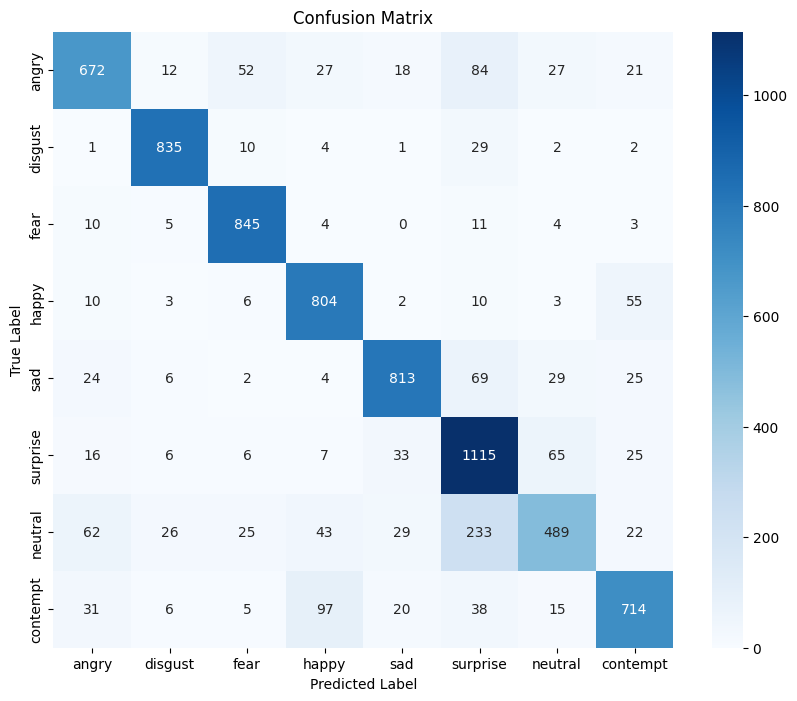

In [4]:
plot_confusion_matrix(y_true, y_pred_classes, class_names)


--- Classification Report ---


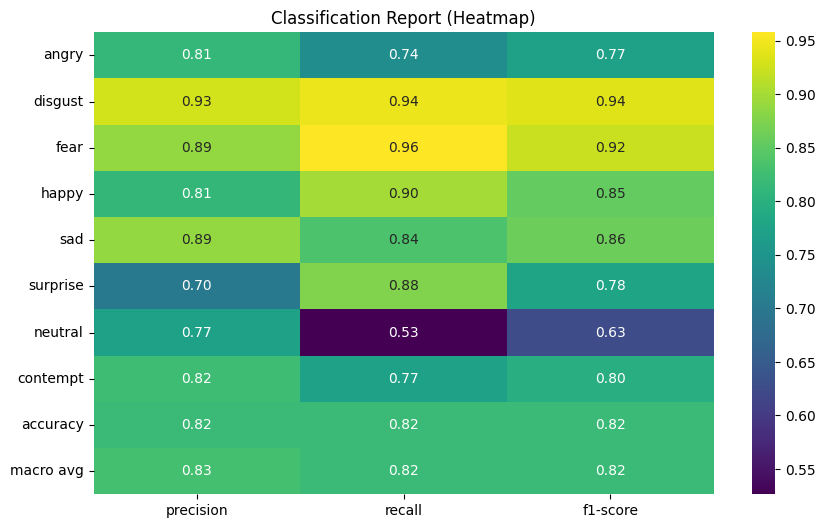

              precision    recall  f1-score   support

       angry       0.81      0.74      0.77       913
     disgust       0.93      0.94      0.94       884
        fear       0.89      0.96      0.92       882
       happy       0.81      0.90      0.85       893
         sad       0.89      0.84      0.86       972
    surprise       0.70      0.88      0.78      1273
     neutral       0.77      0.53      0.63       929
    contempt       0.82      0.77      0.80       926

    accuracy                           0.82      7672
   macro avg       0.83      0.82      0.82      7672
weighted avg       0.82      0.82      0.82      7672



In [5]:
plot_classification_report(y_true, y_pred_classes, class_names)


--- ROC Curves & AUC ---


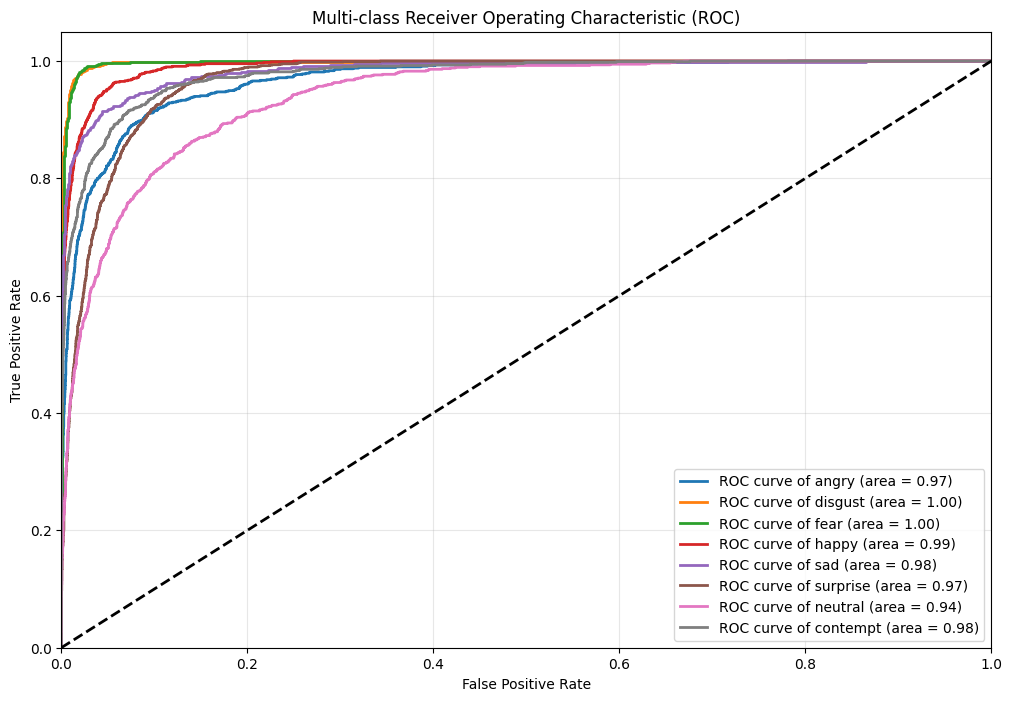

In [6]:
plot_roc_curves(y_true, y_pred_probs, class_names)